# Analyzing out-of-this world data
Using data collected from the Open Exoplanet Catalogue database: https://github.com/OpenExoplanetCatalogue/open_exoplanet_catalogue/

## Data License
Copyright (C) 2012 Hanno Rein

Permission is hereby granted, free of charge, to any person obtaining a copy of this database and associated scripts (the "Database"), to deal in the Database without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Database, and to permit persons to whom the Database is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Database. A reference to the Database shall be included in all scientific publications that make use of the Database.

THE DATABASE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE DATABASE OR THE USE OR OTHER DEALINGS IN THE DATABASE.

## Setup

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## EDA

In [2]:
planets = pd.read_csv('data/planets.csv')
planets.head()

,mass,description,periastrontime,semimajoraxis,discoveryyear,list,eccentricity,period,discoverymethod,lastupdate,periastron,name
0,19.400,11 Com b is a brown dwarf-mass companion to th...,2452899.60,1.290,2008.0,Confirmed planets,0.231,326.03,RV,15/09/20,94.800,11 Com b
1,11.200,11 Ursae Minoris is a star located in the cons...,2452861.04,1.540,2009.0,Confirmed planets,0.080,516.22,RV,15/09/20,117.630,11 UMi b
2,4.800,14 Andromedae is an evolved star in the conste...,2452861.40,0.830,2008.0,Confirmed planets,0.000,185.84,RV,15/09/20,0.000,14 And b
3,4.975,The star 14 Herculis is only 59 light years aw...,NaN,2.864,2002.0,Confirmed planets,0.359,1766.00,RV,15/09/21,22.230,14 Her b
4,7.679,14 Her c is the second companion in the system...,NaN,9.037,2006.0,Controversial,0.184,9886.00,RV,15/09/21,189.076,14 Her c


### Looking for correlated features
It's important to perform an in-depth exploration of the data before modeling. This includes consulting domain experts, looking for correlations between variables, examining distributions, etc. The visualizations covered in chapters 5 and 6 will prove indispensible for this process. One such visualization is the heatmap which we can use to look for correlated features:

<AxesSubplot:>

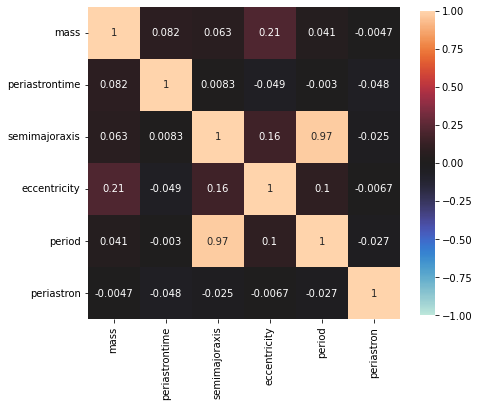

In [3]:
fig = plt.figure(figsize=(7, 7))
sns.heatmap(
    planets.drop(columns='discoveryyear').corr(), 
    center=0, vmin=-1, vmax=1, square=True, annot=True,
    cbar_kws={'shrink': 0.8}
)

### Looking at Orbit shape
| Eccentricity | Orbit Shape |
| :---: | :---: |
| 0 | Circular |
| (0, 1) | Elliptical |
| 1 | Parabolic |
| > 1 | Hyperbolic |

In [4]:
planets.eccentricity.min(), planets.eccentricity.max()

(0.0, 0.956)

All of the planets in the data have circular or elliptical orbits. Let's see the distribution:

Text(0.5, 1.0, 'Orbit Eccentricities')

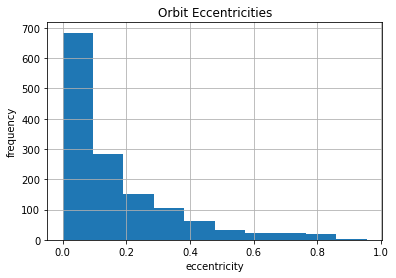

In [5]:
# planets.eccentricity.hist()
planets['eccentricity'].hist()
plt.xlabel('eccentricity')
plt.ylabel('frequency')
plt.title('Orbit Eccentricities')

### Understanding the semi-major axis
An ellipse, being an elongated circle, has 2 axes: **major** and **minor** for the longest and smallest ones, respectively. The *semi*-major axis is half the major axis. When compared to a circle, the axes are like the diameter crossing the entire shape and the semis are akin to the radius being half the diameter.

In [6]:
# from visual_aids import misc_viz
# misc_viz.elliptical_orbit()

### Checking data values
With just the variables of interest, we have a lot of missing data:

In [7]:
planets[['period', 'eccentricity', 'semimajoraxis', 'mass']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4094 entries, 0 to 4093
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   period         3930 non-null   float64
 1   eccentricity   1388 non-null   float64
 2   semimajoraxis  1704 non-null   float64
 3   mass           1659 non-null   float64
dtypes: float64(4)
memory usage: 128.1 KB


If we drop it, we are left with about 30% of it:

In [8]:
planets[['period', 'eccentricity', 'semimajoraxis', 'mass']].dropna().shape

(1222, 4)

We use `describe()` to get a summary of the variables of interest:

In [9]:
planets[['period', 'eccentricity', 'semimajoraxis', 'mass']].describe()

,period,eccentricity,semimajoraxis,mass
count,3930.000000,1388.000000,1704.000000,1659.000000
mean,524.084969,0.159016,5.837964,2.702061
std,7087.428665,0.185041,110.668743,8.526177
min,0.090706,0.000000,0.004420,0.000008
25%,4.552475,0.013000,0.051575,0.085000
50%,12.364638,0.100000,0.140900,0.830000
75%,46.793136,0.230000,1.190000,2.440000
max,320000.000000,0.956000,3500.000000,263.000000


### Visualizing Year and Orbit Length
We have information on the planet list each planet belongs to. We may be wondering: are these planets are controversial because they are so far away?

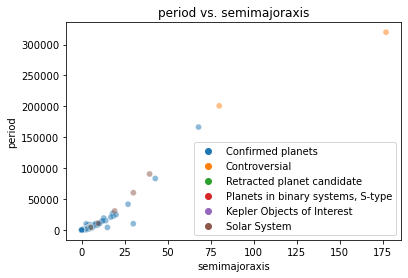

In [10]:
sns.scatterplot(
    # x=planets.semimajoraxis, y=planets.period,
    # hue=planets.list, alpha=0.5
    x=planets['semimajoraxis'], y=planets['period'],
    hue=planets['list'], alpha=0.5
)
plt.title('period vs. semimajoraxis')
plt.legend(title='')

Since semi-major axis is highly correlated with period, let's see how the planets compare and label those in our solar system:

Text(0.5, 1.0, 'log(orbital period) vs. semi-major axis')

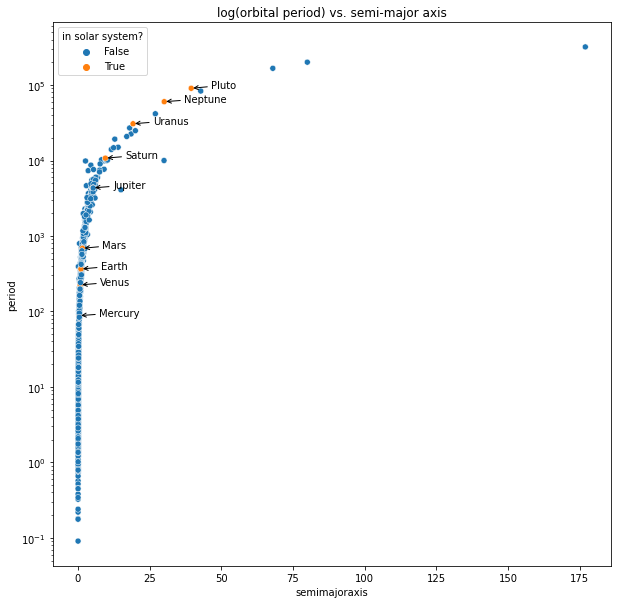

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# in_solar_system = (planets.list == 'Solar System').rename('in solar system?')
in_solar_system = (planets['list'] == 'Solar System').rename('in solar system?')
sns.scatterplot(
    # x=planets.semimajoraxis, 
    # y=planets.period, 
    x=planets['semimajoraxis'] ,
    y=planets['period'], 
    hue=in_solar_system,
    ax=ax
)

ax.set_yscale('log')
# solar_system = planets[planets.list == 'Solar System']
solar_system = planets[planets['list'] == 'Solar System']
for planet in solar_system['name']:
    data = solar_system.query(f'name == "{planet}"')
    ax.annotate(
        planet, 
        (data.semimajoraxis, data.period), 
        (7 + data.semimajoraxis, data.period),
        arrowprops=dict(arrowstyle='->')
    )
ax.set_title('log(orbital period) vs. semi-major axis')

## Finding Similar Planets with k-Means Clustering
Since we want to perform clustering to learn more about the data, we will build our pipeline standardizing the data before running k-means and fit it on the all the data:

In [12]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

kmeans_pipeline = Pipeline([
    ('scale', StandardScaler()), 
    ('kmeans', KMeans(8, random_state=0))
])

kmeans_pipeline

Pipeline(steps=[('scale', StandardScaler()),
                ('kmeans', KMeans(random_state=0))])

Grab the data and fit the model:

In [23]:
kmeans_data = planets[['semimajoraxis', 'period']].dropna()
# kmeans_data
kmeans_pipeline.fit(kmeans_data)
# kmeans_data

Pipeline(steps=[('scale', StandardScaler()),
                ('kmeans', KMeans(random_state=0))])

We can recreate our plot from before and this time, color by the cluster k-means put each planet in:

Text(0.5, 1.0, 'KMeans Clusters')

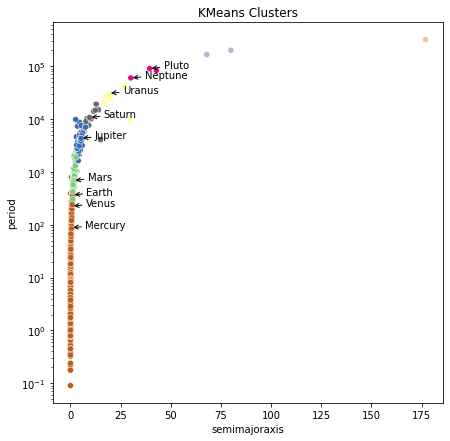

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.scatterplot(
    # x=kmeans_data.semimajoraxis, 
    # y=kmeans_data.period, 
    x=kmeans_data['semimajoraxis'], 
    y=kmeans_data['period'], 
    hue=kmeans_pipeline.predict(kmeans_data),
    ax=ax, palette='Accent'
)
ax.set_yscale('log')
solar_system = planets[planets.list == 'Solar System']
for planet in solar_system.name:
    data = solar_system.query(f'name == "{planet}"')
    ax.annotate(
        planet, 
        (data.semimajoraxis, data.period), 
        (7 + data.semimajoraxis, data.period),
        arrowprops=dict(arrowstyle='->')
    )
ax.get_legend().remove()
ax.set_title('KMeans Clusters')

The elbow point method can be used to pick a good value for `k`. This value will be were we begin to see diminishing returns in the reduction of the value of the objective function:

In [ ]:
from ml_utils.elbow_point import elbow_point

ax = elbow_point(
    kmeans_data, 
    Pipeline([
        ('scale', StandardScaler()), 
        ('kmeans', KMeans(random_state=0))
    ])
)
ax.annotate(
    'possible appropriate values for k', xy=(2, 900), xytext=(2.5, 1500), 
    arrowprops=dict(arrowstyle='->')
)
ax.annotate(
    '', xy=(3, 480), xytext=(4.4, 1450), arrowprops=dict(arrowstyle='->')
)

k-means with the "optimal" k of 2

In [ ]:
kmeans_pipeline_2 = Pipeline([
    ('scale', StandardScaler()), 
    ('kmeans', KMeans(2, random_state=0))
]).fit(kmeans_data)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.scatterplot(
    x=kmeans_data.semimajoraxis, 
    y=kmeans_data.period, 
    hue=kmeans_pipeline_2.predict(kmeans_data),
    ax=ax
)
ax.set_yscale('log')
solar_system = planets[planets.list == 'Solar System']
for planet in solar_system.name:
    data = solar_system.query(f'name == "{planet}"')
    ax.annotate(
        planet, 
        (data.semimajoraxis, data.period), 
        (7 + data.semimajoraxis, data.period),
        arrowprops=dict(arrowstyle='->')
    )
ax.get_legend().remove()
ax.set_title('KMeans Clusters')

### Visualizing the cluster space
Since we standardized the data, looking at the centers tells us the second cluster contains "outliers" for period and semi-major axis:

In [ ]:
kmeans_pipeline_2.named_steps['kmeans'].cluster_centers_

We can also visualize the clusters:

In [ ]:
# set up layout
fig = plt.figure(figsize=(8, 6))
outside = fig.add_axes([0.1, 0.1, 0.9, 0.9])
inside = fig.add_axes([0.6, 0.2, 0.35, 0.35])

# scaled data and cluster distance data
scaled = kmeans_pipeline_2.named_steps['scale']\
    .fit_transform(kmeans_data)
cluster_distances = kmeans_pipeline_2\
    .fit_transform(kmeans_data)

for ax, data, title, axes_labels in zip(
    [outside, inside], [scaled, cluster_distances],  
    ['Visualizing Clusters', 'Cluster Distance Space'], 
    ['standardized', 'distance to centroid']
):
    sns.scatterplot(
        x=data[:,0], y=data[:,1], ax=ax, alpha=0.75, s=100,
        hue=kmeans_pipeline_2.named_steps['kmeans'].labels_
    )

    ax.get_legend().remove()
    ax.set_title(title)
    ax.set_xlabel(f'semimajoraxis ({axes_labels})')
    ax.set_ylabel(f'period ({axes_labels})')
    ax.set_ylim(-1, None)
    
# add the centroids to the outside plot
cluster_centers = kmeans_pipeline_2.named_steps['kmeans'].cluster_centers_
for color, centroid in zip(['blue', 'orange'], cluster_centers):
    outside.plot(*centroid, color=color, marker='x')
    outside.annotate(
        f'{color} center', xy=centroid, xytext=centroid + [0, 5], 
        arrowprops=dict(arrowstyle='->')
    )

#### Notes on the `scikit-learn` API

|Method|Action|Used when...|
|---|---|---|
|`fit()`|Train the model or preprocessor|Modeling, preprocessing|
|`transform()`|Transform the data into the new space|Clustering, preprocessing|
|`fit_transform()`|Run `fit()`, followed by `transform()`|Clustering, preprocessing|
|`score()`|Evaluate the model using the default scoring method|Modeling|
|`predict()`|Use model to predict output values for given inputs|Modeling|
|`fit_predict()`|Run `fit()`, followed by `predict()`|Modeling|
|`predict_proba()`|Like `predict()`, but returns the probability of belonging to each class|Classification|


#### Evaluation of model
There are many metrics to choose from, but since we don't know the true labels of our data, we can only use unsupervised ones. We will use a few different metrics to get a more well-rounded view of our performance:

##### Silhouette Score
- true labels not known
- higher = better defined (more separated) clusters
- -1 is worst, 1 is best, near 0 indicates overlapping clusters

In [ ]:
from sklearn.metrics import silhouette_score
silhouette_score(kmeans_data, kmeans_pipeline.predict(kmeans_data)) 

##### Davies-Bouldin Score
- true labels not known
- ratio of within-cluster distances to between-cluster distances
- zero is the best partition 

In [ ]:
from sklearn.metrics import davies_bouldin_score
davies_bouldin_score(kmeans_data, kmeans_pipeline.predict(kmeans_data)) 

##### Calinski and Harabasz Score
- true labels not known
- higher = better defined (more separated) clusters

In [ ]:
from sklearn.metrics import calinski_harabasz_score
calinski_harabasz_score(kmeans_data, kmeans_pipeline.predict(kmeans_data)) 

## Predicting Length of Year in Earth Days (Period)
1. separate x and y data, dropping nulls
2. create the training and testing sets
3. train a linear regression model (no preprocessing since we want to interpret the coefficients)
4. isolate the coefficients from the model
5. evaluate the model

Step 1:

In [ ]:
data = planets[
    ['semimajoraxis', 'period', 'mass', 'eccentricity']
].dropna()
X = data[['semimajoraxis', 'mass', 'eccentricity']]
y = data.period

Step 2:

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0
)

### Linear Regression
Step 3:

In [ ]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression().fit(X_train, y_train)

### Get equation
Step 4:

In [ ]:
# get intercept
lm.intercept_

In [ ]:
# get coefficients
[(col, coef) for col, coef in zip(X_train.columns, lm.coef_)]

### Evaluation of model
Step 5

In order to evaluate our model's predictions against the actual values, we need to make predictions for the test set:

In [ ]:
preds = lm.predict(X_test)

We can then plot the predictions and actual values:

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(5, 3))
axes.plot(X_test.semimajoraxis, y_test, 'ob', label='actuals', alpha=0.5)
axes.plot(X_test.semimajoraxis, preds, 'or', label='predictions', alpha=0.5)
axes.set(xlabel='semimajoraxis', ylabel='period')
axes.legend()
axes.set_title('Linear Regression Results')

The correlation between the predictions and the actual values tells us they trend together, but we need to look at other metrics to quantify the errors our model makes:

In [ ]:
np.corrcoef(y_test, preds)[0][1]

#### Residuals
Our residuals have no pattern (left subplot); however, the distribution has some negative skew, and the residuals aren't quite centered around zero (right subplot):

In [ ]:
from ml_utils.regression import plot_residuals

plot_residuals(y_test, preds)

#### R<sup>2</sup>
By default, the `score()` method of the `LinearRegression` object will give us the $R^2$:

In [ ]:
lm.score(X_test, y_test)

If not, we can use the `r2_score()` function from `sklearn.metrics`:

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test, preds)

#### Adjusted R<sup>2</sup>
$R^2$ increases when we add regressors whether or not they actually improve the model. Adjusted $R^2$ penalizes additional regressors to address this:

In [ ]:
from ml_utils.regression import adjusted_r2
adjusted_r2(lm, X_test, y_test)

#### Problems with R<sup>2</sup>
$R^2$ doesn't tell us about the prediction errors or if we specified the model correctly. Consider Anscombe's quartet from chapter 1:

##### Anscombe's Quartet
All four data sets have the same summary statistics (mean, standard deviation, correlation coefficient), despite having different data:

In [ ]:
anscombe = sns.load_dataset('anscombe').groupby('dataset')
anscombe.describe()

When fitted with a regression line, they all have the same $R^2$ despite some of them not indicating a linear relationship between x and y:

In [ ]:
from visual_aids import stats_viz
stats_viz.anscombes_quartet(r_squared=True)

#### Explained Variance
The percentage of the variance in the data is explained by our model:

In [ ]:
from sklearn.metrics import explained_variance_score
explained_variance_score(y_test, preds)

#### Mean Absolute Error (MAE)
This gives us an idea of how far off our predictions are on average (in Earth days):

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, preds)

#### Root Mean Squared Error (RMSE)
We can use this to punish large errors more:

In [ ]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_test, preds))

#### Median Absolute Error
We can also look at the median absolute error to ignore any outliers in prediction errors and get a better picture of our error:

In [ ]:
from sklearn.metrics import median_absolute_error
median_absolute_error(y_test, preds)

<hr>
<div style="overflow: hidden; margin-bottom: 10px;">
    <div style="float: left;">
        <a href="../../ch_08/anomaly_detection.ipynb">
            <button>&#8592; Chapter 8</button>
        </a>
        <a href="./planet_data_collection.ipynb">
            <button>Planet Data Collection</button>
        </a>
        <a href="./preprocessing.ipynb">
            <button>Preprocessing</button>
        </a>
        <a href="./red_wine.ipynb">
            <button>Red Wine</button>
        </a>
        <a href="./wine.ipynb">
            <button>Red + White Wine</button>
        </a>
    </div>
    <div style="float: right;">
        <a href="../../solutions/ch_09/exercise_1.ipynb">
            <button>Solutions</button>
        </a>
        <a href="../ch_10/red_wine.ipynb">
            <button>Chapter 10 &#8594;</button>
        </a>
    </div>
</div>
<hr>